# 3.3.1 Data Cleaning

## 3.3.1.1	Handling Missing Values

In [1]:
import pandas as pd
# from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# read the data
train_data = pd.read_csv('data/train.csv')
train_data.drop(train_data.columns[14:6001], axis=1, inplace=True)

In [6]:
train_data.head()

,id,1,2,3,4,5,6,7,8,9,10,11,12,13,label
0,1,0.563650,1.069229,-0.837759,-1.122021,0.433296,0.770755,-0.477153,-0.588421,0.455224,0.555122,-0.215227,-0.197765,0.596543,7
1,2,0.061333,0.058830,0.056952,NaN,0.073433,0.072390,NaN,-0.007302,-0.026286,-0.006050,0.028789,0.026286,-0.003546,0
2,3,NaN,0.010964,-0.164872,-0.167714,-0.125075,-0.104771,-0.016650,0.151471,0.137258,0.045076,NaN,0.175836,0.092588,9
3,4,-0.046700,0.060913,0.009340,-0.093400,-0.067817,0.022335,NaN,-0.076751,-0.032893,0.023553,-0.017056,-0.024365,-0.005279,9
4,5,0.162922,-0.377662,0.014457,0.565437,-0.203369,-0.511508,0.410961,NaN,NaN,0.013157,0.328606,-0.224973,-0.227734,7


In [4]:
# shape and data types of the data
print(train_data.shape)
print(train_data.describe())

(792, 15)
                1           2           3           4           5           6  \
count  744.000000  792.000000  792.000000  738.000000  792.000000  792.000000   
mean     0.015749    0.012040    0.017170    0.025472    0.008569    0.001804   
std      0.342030    0.355835    0.351182    0.351379    0.337050    0.341250   
min     -1.988206   -2.219676   -2.544546   -2.423126   -1.911049   -2.724443   
25%     -0.078444   -0.080855   -0.065244   -0.067956   -0.085319   -0.083498   
50%      0.008749    0.009590    0.012995    0.018558    0.011127    0.010396   
75%      0.090436    0.091066    0.103003    0.110253    0.094822    0.091371   
max      2.635510    2.268407    2.478354    2.847488    2.280589    2.712261   

                7           8           9          10          11          12  \
count  728.000000  791.000000  502.000000  792.000000  734.000000  792.000000   
mean     0.002242    0.009581    0.000458    0.002271    0.006070    0.009901   
std      0.355156

### Finding Missing Values

#### Technique 1: Missing Data Heatmap

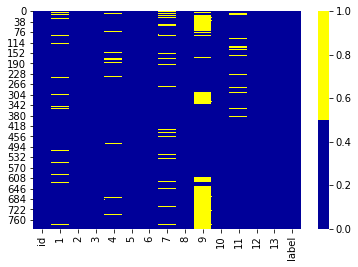

In [7]:
cols = train_data.columns[:] # all columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(train_data[cols].isnull(), cmap=sns.color_palette(colours))


#### Technique 2: Missing Data Percentage List

In [8]:
# if it's a larger dataset and the visualization takes too long can do this.
# % of missing.
for col in train_data.columns:
    pct_missing = np.mean(train_data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

id - 0.0%
1 - 6.0%
2 - 0.0%
3 - 0.0%
4 - 7.0%
5 - 0.0%
6 - 0.0%
7 - 8.0%
8 - 0.0%
9 - 37.0%
10 - 0.0%
11 - 7.0%
12 - 0.0%
13 - 0.0%
label - 0.0%


#### Technique 3: Missing Data Histogram

created missing indicator for: 1
created missing indicator for: 4
created missing indicator for: 7
created missing indicator for: 8
created missing indicator for: 9
created missing indicator for: 11


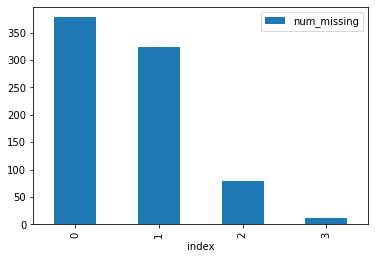

In [9]:
# first create missing indicator for features with missing data
for col in train_data.columns:
    missing = train_data[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        train_data['{}_ismissing'.format(col)] = missing


# then based on the indicator, plot the histogram of missing values
ismissing_cols = [col for col in train_data.columns if 'ismissing' in col]
train_data['num_missing'] = train_data[ismissing_cols].sum(axis=1)

train_data['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')


### Solutions to Missing Values

#### Statistical Imputation

In [29]:

# statistical imputation transform for the milling dataset 
from numpy import isnan 
from sklearn.impute import SimpleImputer

# read the data
train_data = pd.read_csv('data/train.csv')
train_data.drop(train_data.columns[600:6000], axis=1, inplace=True)

# split into input and output elements
data = train_data.values
ix = [i for i in range(data.shape[1]) if i != 600] 
X, y = data[:, ix], data[:, 600] 
# summarize total missing 
print('Missing: %d' % sum(isnan(X).flatten()))
# define imputer 
imputer = SimpleImputer(strategy='mean')
# fit on the dataset 
imputer.fit(X)
# transform the dataset 
Xtrans = imputer.transform(X)
# summarize total missing 
print('Missing: %d' % sum(np.isnan(Xtrans).flatten()))

Missing: 654
Missing: 0


In [30]:
## Comparing Different Imputed Statistics

from numpy import mean
from numpy import std
from pandas import read_csv 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.pipeline import Pipeline 
from matplotlib import pyplot
from scipy import stats

In [31]:
# read data
train_data = pd.read_csv('data/train.csv')
train_data.drop(train_data.columns[600:6000], axis=1, inplace=True)
y_train = pd.DataFrame()
y_train['label'] = train_data['label']
train_data.drop(columns='label', inplace=True)

In [32]:
## compute time series data feature
def get_t(df):
    mean_list = []
    std_list = []
    var_list = []
    min_list = []
    max_list = []
    median_list = []
    skew_list = []
    kuri_list = []
    x = pd.DataFrame()
    for i in range(len(df)):
        mean_list.append(np.mean(train_data.iloc[i][1:].values))
        std_list.append(np.std(train_data.iloc[i][1:].values))
        var_list.append(np.var(train_data.iloc[i][1:].values))
        min_list.append(np.min(train_data.iloc[i][1:].values))
        max_list.append(np.max(train_data.iloc[i][1:].values))
        median_list.append(np.median(train_data.iloc[i][1:].values))
        skew_list.append(stats.skew(train_data.iloc[i][1:].values))
        kuri_list.append(stats.kurtosis(train_data.iloc[i][1:].values))
    x['mean'] = mean_list
    x['std'] = std_list
    x['var'] = var_list
    x['min'] = min_list
    x['max'] = max_list
    x['median'] = median_list
    x['skew'] = skew_list
    x['kuri'] = kuri_list
    return x

>mean 0.861 (0.039)
>median 0.856 (0.043)
>most_frequent 0.853 (0.037)
>constant 0.856 (0.039)


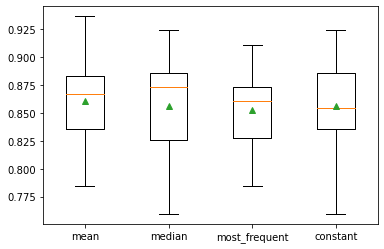

In [39]:
# evaluate each strategy on the dataset 
results = list() 
strategies = ['mean', 'median', 'most_frequent', 'constant']
for s in strategies:
    # define imputer 
    imputer = SimpleImputer(strategy=s)
    # fit on the dataset 
    imputer.fit(train_data)
    # transform the dataset 
    trans_data = imputer.transform(train_data)
    train_data = pd.DataFrame(Xtrans)
    x_train = get_t(train_data)
      
    # evaluate the model
    clf = RandomForestClassifier(n_estimators=50)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
    scores = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    # store results 
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True) 
pyplot.show()

#### Iterative Imputation

In [28]:
from numpy import isnan 
from pandas import read_csv 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

# read the data
train_data = pd.read_csv('data/train.csv')
train_data.drop(train_data.columns[600:6000], axis=1, inplace=True)

# split into input and output elements
data = train_data.values
ix = [i for i in range(data.shape[1]) if i != 600] 
X, y = data[:, ix], data[:, 600] 
# summarize total missing 
print('Missing: %d' % sum(isnan(X).flatten()))
# define imputer 
imputer = IterativeImputer() 
# fit on the dataset 
imputer.fit(X)
# transform the dataset 
Xtrans = imputer.transform(X)
# summarize total missing 
print('Missing: %d' % sum(np.isnan(Xtrans).flatten()))


Missing: 654
Missing: 0


In [6]:
import pandas as pd
import numpy as np
from numpy import mean 
from numpy import std 
from pandas import read_csv 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.pipeline import Pipeline 
from matplotlib import pyplot
from scipy import stats

In [4]:
## read the data
train_data = pd.read_csv('data/train.csv')
train_data.drop(train_data.columns[600:6000], axis=1, inplace=True)
y_train = pd.DataFrame()
y_train['label'] = train_data['label']
train_data.drop(columns='label', inplace=True)

In [8]:
# compute time series data feature
def get_t(df):
    mean_list = []
    std_list = []
    var_list = []
    min_list = []
    max_list = []
    median_list = []
    skew_list = []
    kuri_list = []
    x = pd.DataFrame()
    for i in range(len(df)):
        mean_list.append(np.mean(train_data.iloc[i][1:].values))
        std_list.append(np.std(train_data.iloc[i][1:].values))
        var_list.append(np.var(train_data.iloc[i][1:].values))
        min_list.append(np.min(train_data.iloc[i][1:].values))
        max_list.append(np.max(train_data.iloc[i][1:].values))
        median_list.append(np.median(train_data.iloc[i][1:].values))
        skew_list.append(stats.skew(train_data.iloc[i][1:].values))
        kuri_list.append(stats.kurtosis(train_data.iloc[i][1:].values))
    x['mean'] = mean_list
    x['std'] = std_list
    x['var'] = var_list
    x['min'] = min_list
    x['max'] = max_list
    x['median'] = median_list
    x['skew'] = skew_list
    x['kuri'] = kuri_list
    return x

>ascending 0.857 (0.044)
>descending 0.856 (0.040)
>roman 0.850 (0.038)
>arabic 0.852 (0.039)
>random 0.857 (0.041)


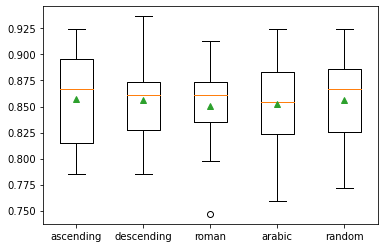

In [9]:
# evaluate each strategy on the dataset 
results = list() 
strategies = ['ascending', 'descending', 'roman', 'arabic', 'random'] 
for s in strategies:
    # define imputer 
    imputer = IterativeImputer(imputation_order=s)
    # fit on the dataset 
    imputer.fit(train_data)
    # transform the dataset 
    Xtrans = imputer.transform(train_data)
    train_data = pd.DataFrame(Xtrans)
    x_train = get_t(train_data)
    
    # evaluate the model
    clf = RandomForestClassifier(n_estimators=50)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
    scores = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    # store results 
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True) 
pyplot.show()

In [169]:
# compare iterative imputation number of iterations for the bearing dataset 
from numpy import mean 
from numpy import std 
from pandas import read_csv 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.pipeline import Pipeline 
from matplotlib import pyplot
from scipy import stats

In [11]:
## read the data
train_data = pd.read_csv('data/train.csv')
train_data.drop(train_data.columns[600:6000], axis=1, inplace=True)
y_train = pd.DataFrame()
y_train['label'] = train_data['label']
train_data.drop(columns='label', inplace=True)

In [12]:
# compute time series data feature
def get_t(df):
    mean_list = []
    std_list = []
    var_list = []
    min_list = []
    max_list = []
    median_list = []
    skew_list = []
    kuri_list = []
    x = pd.DataFrame()
    for i in range(len(df)):
        mean_list.append(np.mean(train_data.iloc[i][1:].values))
        std_list.append(np.std(train_data.iloc[i][1:].values))
        var_list.append(np.var(train_data.iloc[i][1:].values))
        min_list.append(np.min(train_data.iloc[i][1:].values))
        max_list.append(np.max(train_data.iloc[i][1:].values))
        median_list.append(np.median(train_data.iloc[i][1:].values))
        skew_list.append(stats.skew(train_data.iloc[i][1:].values))
        kuri_list.append(stats.kurtosis(train_data.iloc[i][1:].values))
    x['mean'] = mean_list
    x['std'] = std_list
    x['var'] = var_list
    x['min'] = min_list
    x['max'] = max_list
    x['median'] = median_list
    x['skew'] = skew_list
    x['kuri'] = kuri_list
    return x

In [ ]:
# evaluate each strategy on the dataset 
results = list() 
strategies = [str(i) for i in range(1, 16)]
for s in strategies:
    # define imputer 
    imputer = IterativeImputer(max_iter=int(s))
    # fit on the dataset 
    imputer.fit(train_data)
    # transform the dataset 
    Xtrans = imputer.transform(train_data)
    train_data = pd.DataFrame(Xtrans)
    x_train = get_t(train_data)
    
    # evaluate the model
    clf = RandomForestClassifier()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
    scores = cross_val_score(clf, x_train, y_train.values.ravel(), scoring='accuracy', cv=cv, n_jobs=1)
    # store results 
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True) 
pyplot.show()

#### Model-based Imputation (KNN)

In [22]:
# knn imputation transform for the bearing dataset 
from numpy import isnan 
from pandas import read_csv 
from sklearn.impute import KNNImputer

# read the data
train_data = read_csv('data/train.csv')
train_data.drop(train_data.columns[600:6000], axis=1, inplace=True)

# split into input and output elements
data = train_data.values
ix = [i for i in range(data.shape[1]) if i != 600] 
X, y = data[:, ix], data[:, 600] 
# summarize total missing 
print('Missing: %d' % sum(isnan(X).flatten()))
# define imputer 
imputer = KNNImputer() 
# fit on the dataset 
imputer.fit(X)
# transform the dataset 
Xtrans = imputer.transform(X)
# summarize total missing 
print('Missing: %d' % sum(isnan(Xtrans).flatten()))


Missing: 654
Missing: 0


#### KNNImputer and Different Number of Neighbors

In [1]:
import pandas as pd
import numpy as np
from numpy import mean 
from numpy import std 
from pandas import read_csv 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.impute import KNNImputer 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.pipeline import Pipeline 
from matplotlib import pyplot
from scipy import stats

In [7]:
## read the data
train_data = pd.read_csv('data/train.csv')
train_data.drop(train_data.columns[600:6000], axis=1, inplace=True)
y_train = pd.DataFrame()
y_train['label'] = train_data['label']
train_data.drop(columns='label', inplace=True)

In [3]:
# compute time series data feature
def get_t(df):
    mean_list = []
    std_list = []
    var_list = []
    min_list = []
    max_list = []
    median_list = []
    skew_list = []
    kuri_list = []
    x = pd.DataFrame()
    for i in range(len(df)):
        mean_list.append(np.mean(train_data.iloc[i][1:].values))
        std_list.append(np.std(train_data.iloc[i][1:].values))
        var_list.append(np.var(train_data.iloc[i][1:].values))
        min_list.append(np.min(train_data.iloc[i][1:].values))
        max_list.append(np.max(train_data.iloc[i][1:].values))
        median_list.append(np.median(train_data.iloc[i][1:].values))
        skew_list.append(stats.skew(train_data.iloc[i][1:].values))
        kuri_list.append(stats.kurtosis(train_data.iloc[i][1:].values))
    x['mean'] = mean_list
    x['std'] = std_list
    x['var'] = var_list
    x['min'] = min_list
    x['max'] = max_list
    x['median'] = median_list
    x['skew'] = skew_list
    x['kuri'] = kuri_list
    return x

>1 0.861 (0.034)
>3 0.856 (0.039)
>5 0.860 (0.039)
>7 0.859 (0.039)
>9 0.863 (0.034)
>15 0.861 (0.038)
>18 0.859 (0.034)
>21 0.861 (0.038)


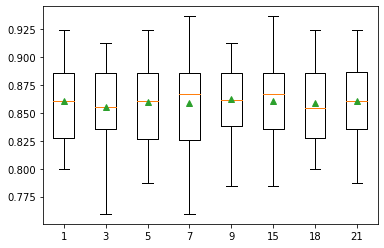

In [12]:
# evaluate each strategy on the dataset 
results = list() 
strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
for s in strategies:
    # define imputer 
    imputer = KNNImputer(n_neighbors=int(s))
    # fit on the dataset 
    imputer.fit(train_data)
    # transform the dataset 
    Xtrans = imputer.transform(train_data)
    train_data = pd.DataFrame(Xtrans)
    x_train = get_t(train_data)
    
    # evaluate the model
    clf = RandomForestClassifier()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
    scores = cross_val_score(clf, x_train, y_train.values.ravel(), scoring='accuracy', cv=cv, n_jobs=1)
    # store results 
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True) 
pyplot.show()

## 3.3.1.2	Outlier Detection and Solutions

### •	Test Dataset

In [3]:
import pandas as pd
# from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
# read the data
train_data = pd.read_csv('data/train_complete.csv')
train_data.drop(columns=['label','id'], inplace=True)
train_data.drop(train_data.columns[5:6001], axis=1, inplace=True)

### Univariate Outliers Detection

#### Visualizing Outliers

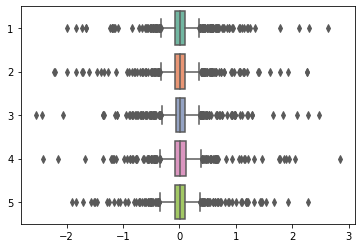

In [31]:
#Visualizing Outliers
ax = sns.boxplot(data=train_data, orient="h", palette="Set2")

#### Tukey's method

probable outliers: 46 
 [48, 55, 57, 78, 86, 99, 121, 144, 149, 160, 189, 204, 216, 240, 262, 291, 299, 306, 324, 345, 364, 365, 369, 409, 429, 432, 440, 469, 472, 484, 520, 541, 595, 644, 670, 694, 696, 703, 714, 723, 759, 763, 766, 767, 771, 788] 

possible outliers: 106 
 [0, 10, 13, 23, 27, 43, 44, 46, 48, 52, 55, 57, 58, 78, 86, 99, 110, 121, 125, 133, 144, 149, 152, 156, 160, 173, 175, 181, 189, 204, 216, 217, 235, 238, 240, 241, 244, 251, 253, 262, 270, 280, 291, 299, 306, 324, 336, 342, 345, 352, 358, 364, 365, 367, 369, 380, 388, 396, 409, 414, 422, 429, 432, 440, 441, 469, 472, 484, 490, 504, 520, 530, 541, 563, 587, 595, 599, 601, 604, 626, 644, 645, 670, 689, 690, 694, 695, 696, 703, 710, 711, 714, 716, 722, 723, 725, 754, 758, 759, 763, 766, 767, 769, 771, 775, 788]


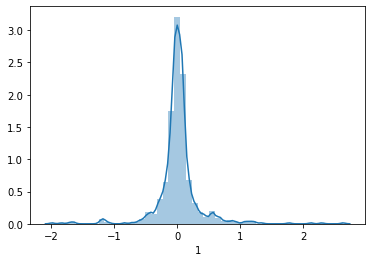

In [51]:
#Tukey's method
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss
        
sns.distplot(train_data['1'])

probable_outliers_tm, possible_outliers_tm = tukeys_method(train_data, "1")
print('probable outliers: %d' % len(probable_outliers_tm), "\n", probable_outliers_tm, "\n")
print('possible outliers: %d' % len(possible_outliers_tm), "\n", possible_outliers_tm)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


probable outliers logiq: 38 
 [23, 48, 52, 55, 58, 86, 144, 175, 204, 235, 238, 240, 244, 262, 291, 299, 306, 364, 365, 367, 369, 380, 396, 432, 472, 520, 595, 601, 644, 694, 696, 716, 722, 723, 758, 759, 763, 788] 

possible outliers logiq: 104 
 [0, 10, 13, 19, 20, 23, 27, 43, 44, 48, 52, 55, 58, 78, 86, 99, 110, 118, 125, 133, 136, 144, 152, 156, 173, 175, 181, 189, 191, 204, 217, 223, 235, 238, 240, 241, 244, 250, 251, 253, 262, 270, 280, 291, 299, 306, 324, 336, 342, 344, 345, 358, 364, 365, 367, 369, 380, 388, 396, 403, 414, 422, 432, 433, 441, 472, 480, 484, 490, 504, 520, 530, 541, 563, 587, 595, 599, 601, 604, 606, 612, 626, 644, 645, 689, 690, 694, 695, 696, 702, 710, 716, 722, 723, 754, 758, 759, 763, 766, 767, 775, 780, 788, 789]


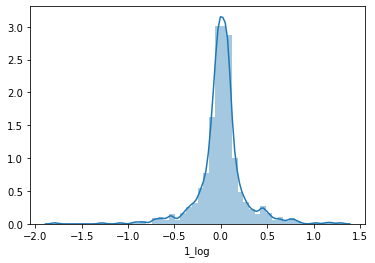

In [50]:
#Transform variable to log 
log_1 = np.log(train_data["1"])
train_data["1_man"] = train_data["1"]+1
log_1 = np.log(train_data['1_man'])
train_data['1_log'] = log_1

#Plot
sns.distplot(train_data['1_log'])

#Calculate probable and possible outliers using log-iq method
probable_outliers_logiq, possible_outliers_logiq = tukeys_method(train_data, '1_log')
print('probable outliers logiq: %d' % len(probable_outliers_logiq), "\n", probable_outliers_logiq, "\n")
print('possible outliers logiq: %d' % len(possible_outliers_logiq), "\n", possible_outliers_logiq)

#### Z-Score

In [6]:
from scipy import stats

In [56]:
#Z-Score
def z_score_method(df, variable_name):
    #Takes two parameters: dataframe & variable of interest as string
    columns = df.columns
    z = np.abs(stats.zscore(df))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable_name:
            index = item
    for i, v in enumerate(z[:, index]):
        if v > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

outlier_z = z_score_method(train_data, '1')
print('outliers: %d' % len(outlier_z), "\n", outlier_z)

outliers: 25 
 [48, 57, 121, 149, 160, 204, 216, 262, 306, 369, 409, 429, 432, 440, 469, 472, 520, 644, 670, 703, 714, 759, 763, 771, 788]


#### MAD method

In [58]:
#MAD method
def mad_method(df, variable_name):
    #Takes two parameters: dataframe & variable of interest as string
    columns = df.columns
    med = np.median(df, axis = 0)
    mad = np.abs(stats.median_abs_deviation(df))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable_name:
            index == item
    for i, v in enumerate(df.loc[:,variable_name]):
        t = (v-med[index])/mad[index]
        if t > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

outlier_mad = mad_method(train_data, '1')
print('outliers: %d' % len(outlier_mad), "\n", outlier_mad)

outliers: 78 
 [0, 13, 27, 43, 44, 46, 48, 55, 70, 78, 99, 105, 110, 134, 140, 144, 145, 152, 173, 185, 189, 198, 204, 217, 241, 262, 271, 280, 299, 302, 306, 324, 336, 342, 345, 352, 358, 364, 369, 388, 414, 422, 432, 441, 472, 484, 504, 510, 512, 516, 520, 531, 541, 549, 558, 587, 594, 595, 604, 626, 644, 645, 690, 694, 696, 701, 710, 711, 725, 742, 754, 759, 763, 766, 767, 769, 775, 788]


### Multivariate Outliers Detection

#### Visualizing Outliers

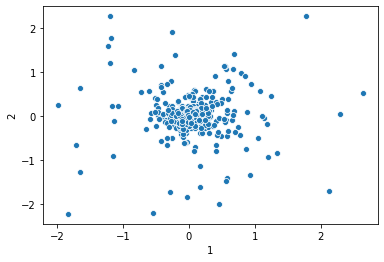

In [59]:
#Scatterpblot
ax = sns.scatterplot(x="1", y="2", data=train_data)

#### Mahalonibis Distance

In [20]:
#Mahalonibis Distance
import scipy as sp
from scipy.stats import chi2

def mahalanobis_method(df):
    #M-Distance
    x_minus_mu = df - np.mean(df)
    cov = np.cov(df.values.T)                           #Covariance
    inv_covmat = sp.linalg.inv(cov)                     #Inverse covariance
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    #Cut-off point
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))    #degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

bivariate = train_data[['1','2']]
outliers_mahal_bi, md_bi = mahalanobis_method(df=bivariate)

outliers_mahal, md = mahalanobis_method(df=train_data)

print('bivariate_outliers: %d' % len(outliers_mahal_bi), "\n", outliers_mahal_bi, "\n")
print('multivariate_outliers: %d' % len(outliers_mahal), "\n", outliers_mahal)

bivariate_outliers: 29 
 [14, 48, 57, 99, 110, 121, 149, 160, 171, 197, 344, 380, 409, 429, 469, 472, 520, 626, 644, 645, 670, 682, 694, 703, 714, 723, 759, 763, 788] 

multivariate_outliers: 48 
 [0, 14, 20, 48, 55, 57, 86, 99, 110, 121, 149, 157, 160, 171, 197, 204, 216, 278, 324, 344, 364, 369, 380, 400, 409, 429, 433, 461, 463, 469, 472, 484, 520, 563, 587, 595, 644, 645, 670, 682, 694, 696, 703, 714, 759, 763, 771, 788]


#### Minimum Covariance Determinant (MCD)

In [27]:
#Robust Mahalonibis Distance
from sklearn.covariance import MinCovDet

def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob_bi, md_rb_bi = robust_mahalanobis_method(df=bivariate)
outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=train_data)

print('bivariate_outliers: %d' % len(outliers_mahal_rob_bi), "\n", outliers_mahal_rob_bi, "\n")
print('multivariate_outliers: %d' % len(outliers_mahal_rob), "\n", outliers_mahal_rob)

bivariate_outliers: 41 
 [14, 48, 55, 57, 99, 110, 121, 149, 160, 171, 173, 197, 216, 262, 306, 344, 364, 380, 409, 429, 432, 440, 469, 472, 484, 520, 563, 587, 626, 644, 645, 670, 682, 694, 703, 714, 723, 759, 763, 771, 788] 

multivariate_outliers: 53 
 [0, 14, 20, 48, 55, 57, 86, 99, 110, 121, 149, 157, 160, 171, 173, 197, 204, 216, 241, 278, 324, 344, 364, 369, 380, 400, 409, 429, 432, 433, 461, 463, 469, 472, 484, 520, 563, 587, 595, 626, 644, 645, 670, 682, 694, 696, 703, 714, 723, 759, 763, 771, 788]


### Automatic Outlier Detection

#### Isolation Forest (iForest)

In [36]:

from sklearn.ensemble import IsolationForest

In [61]:

# Returns 1 of inliers, -1 for outliers
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=4, 
                          bootstrap=False, n_jobs=-1, random_state=1)

pred= iforest.fit_predict(train_data)
train_data['scores']=iforest.decision_function(train_data)
train_data['anomaly_label']=pred

In [67]:
outliers = train_data[train_data.anomaly_label==-1]
print(outliers.head(),"\n","\n", 'outliers: %d' % len(outliers), "\n", outliers.index.tolist())

           1         2         3         4         5    scores  anomaly_label
0   0.563650  1.069229 -0.837759 -1.122021  0.433296 -0.029358             -1
48  2.296021  0.057664 -2.069017 -0.777658  1.536230 -0.140959             -1
55  0.790653  0.972580 -0.815424 -1.181309  0.879992 -0.039688             -1
57 -1.195116  1.198365  0.753293 -1.351054  0.148222 -0.052192             -1
86 -0.608320  0.561213  1.220700 -0.108832 -1.467195 -0.035463             -1 
 
 outliers: 40 
 [0, 48, 55, 57, 86, 99, 110, 121, 149, 160, 171, 204, 216, 240, 324, 344, 380, 400, 409, 429, 432, 440, 469, 472, 520, 563, 595, 626, 644, 645, 670, 682, 694, 703, 714, 723, 759, 763, 771, 788]


#### LOF

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [87]:
# read the data
data = pd.read_csv('data/train_complete.csv')
data.drop(columns=['label','id'], inplace=True)
data.drop(data.columns[2:6001], axis=1, inplace=True)

In [96]:
# model specification
clf = LocalOutlierFactor(n_neighbors = 5, contamination = 0.1)
# model fitting
pred = clf.fit_predict(data)
X_scores = clf.negative_outlier_factor_

data['LOF']= -X_scores
data['anomaly_label']=pred
outliers = data[data.anomaly_label == -1]
print(outliers.head(),"\n","\n", 'outliers: %d' % len(outliers), "\n", outliers.index.tolist())

           1         2       LOF  anomaly_label
4   0.162922 -0.377662  1.900779             -1
6  -0.045076 -0.375631  1.518261             -1
14 -0.260302  1.916735  3.241924             -1
18  0.054822  0.340302  1.438465             -1
47  0.240404 -0.276140  1.845152             -1 
 
 outliers: 79 
 [4, 6, 14, 18, 47, 48, 49, 57, 62, 67, 70, 74, 99, 121, 133, 134, 140, 142, 144, 148, 160, 202, 204, 208, 216, 225, 234, 238, 263, 270, 278, 291, 308, 320, 340, 344, 360, 365, 369, 380, 383, 390, 400, 401, 429, 433, 437, 440, 446, 451, 466, 469, 472, 485, 486, 497, 514, 520, 543, 549, 608, 609, 644, 654, 658, 659, 670, 671, 685, 695, 711, 714, 716, 742, 752, 771, 772, 780, 788]


In [97]:
# read the data
data = pd.read_csv('data/train_complete.csv')
data.drop(columns=['label','id'], inplace=True)
data.drop(data.columns[5:6001], axis=1, inplace=True)

# model specification
clf = LocalOutlierFactor(n_neighbors = 5, contamination = 0.1)
# model fitting
pred = clf.fit_predict(data)
data['scores']= -clf.negative_outlier_factor_
data['anomaly_label']=pred
outliers = data[data.anomaly_label == -1]
print(outliers.head(),"\n","\n", 'outliers: %d' % len(outliers), "\n", outliers.index.tolist())

           1         2         3         4         5    scores  anomaly_label
4   0.162922 -0.377662  0.014457  0.565437 -0.203369  1.743819             -1
14 -0.260302  1.916735 -0.608320 -0.423956  0.226597  1.806394             -1
16 -0.017705  0.072933  0.117928  0.114517  0.270779  2.192290             -1
20 -0.317073  0.150577  1.277715  0.533275 -0.300667  2.100149             -1
42 -0.083492  0.128973  0.000162  0.030375  0.099735  1.740905             -1 
 
 outliers: 80 
 [4, 14, 16, 20, 42, 48, 57, 79, 97, 102, 116, 132, 133, 142, 155, 157, 179, 202, 203, 219, 238, 267, 278, 285, 289, 300, 301, 311, 323, 336, 339, 352, 353, 358, 365, 378, 388, 396, 418, 429, 433, 439, 450, 454, 457, 461, 463, 464, 467, 469, 496, 503, 507, 515, 516, 520, 532, 554, 555, 568, 587, 593, 594, 598, 601, 620, 644, 659, 665, 681, 695, 696, 697, 707, 712, 765, 769, 775, 788, 791]


# 3.3.2 Data Transformation

## 3.3.2.1 Feature Scaling

### Normalization

In [139]:
# read the data
data = pd.read_csv('data/train_complete.csv')
data.drop(columns=['label','id'], inplace=True)
data = data.loc[0:4]
data = data.iloc[:,0:10]

In [140]:
data

,1,2,3,4,5,6,7,8,9,10
0,0.563650,1.069229,-0.837759,-1.122021,0.433296,0.770755,-0.477153,-0.588421,0.455224,0.555122
1,0.061333,0.058830,0.056952,0.068634,0.073433,0.072390,0.042975,-0.007302,-0.026286,-0.006050
2,0.035736,0.010964,-0.164872,-0.167714,-0.125075,-0.104771,-0.016650,0.151471,0.137258,0.045076
3,-0.046700,0.060913,0.009340,-0.093400,-0.067817,0.022335,0.006091,-0.076751,-0.032893,0.023553
4,0.162922,-0.377662,0.014457,0.565437,-0.203369,-0.511508,0.410961,0.228546,-0.515244,0.013157


In [142]:
from sklearn.preprocessing import MinMaxScaler 

minmax_scale = MinMaxScaler().fit_transform(data)

scaled_frame = pd.DataFrame(minmax_scale,columns=data.columns)

scaled_frame


,1,2,3,4,5,6,7,8,9,10
0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
1,0.177002,0.301675,1.000000,0.705591,0.434768,0.455365,0.585654,0.711313,0.503838,0.000000
2,0.135063,0.268594,0.752072,0.565529,0.122975,0.317203,0.518519,0.905657,0.672358,0.091105
3,0.000000,0.303115,0.946785,0.609568,0.212910,0.416329,0.544124,0.626305,0.497029,0.052752
4,0.343446,0.000000,0.952504,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.034227


### Standardization

In [143]:
from sklearn.preprocessing import StandardScaler

standard_scale = StandardScaler().fit_transform(data)

scaled_frame = pd.DataFrame(standard_scale,columns=data.columns)

scaled_frame

,1,2,3,4,5,6,7,8,9,10
0,1.900487,1.880102,-1.947856,-1.770291,1.830556,1.738280,-1.666242,-1.850022,1.437858,1.994103
1,-0.437834,-0.219487,0.719445,0.397770,0.228547,0.054372,0.176153,0.178707,-0.095188,-0.614671
2,-0.556991,-0.318950,0.058147,-0.032597,-0.655153,-0.372800,-0.035048,0.732992,0.425506,-0.376998
3,-0.940735,-0.215158,0.577505,0.102722,-0.400255,-0.066321,0.045505,-0.063745,-0.116226,-0.477053
4,0.035072,-1.126507,0.592759,1.302396,-1.003695,-1.353531,1.479632,1.002068,-1.651950,-0.525381


In [144]:
scaled_frame.describe()

,1,2,3,4,5,6,7,8,9,10
count,5.000000e+00,5.000000e+00,5.000000,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000,5.000000
mean,8.187895e-17,4.440892e-17,0.000000,4.440892e-17,-8.881784e-17,-4.440892e-17,8.881784e-17,4.440892e-17,0.000000,0.000000
std,1.118034e+00,1.118034e+00,1.118034,1.118034e+00,1.118034e+00,1.118034e+00,1.118034e+00,1.118034e+00,1.118034,1.118034
min,-9.407351e-01,-1.126507e+00,-1.947856,-1.770291e+00,-1.003695e+00,-1.353531e+00,-1.666242e+00,-1.850022e+00,-1.651950,-0.614671
25%,-5.569905e-01,-3.189502e-01,0.058147,-3.259675e-02,-6.551530e-01,-3.727996e-01,-3.504802e-02,-6.374455e-02,-0.116226,-0.525381
50%,-4.378338e-01,-2.194874e-01,0.577505,1.027216e-01,-4.002549e-01,-6.632097e-02,4.550475e-02,1.787070e-01,-0.095188,-0.477053
75%,3.507250e-02,-2.151576e-01,0.592759,3.977701e-01,2.285469e-01,5.437170e-02,1.761531e-01,7.329921e-01,0.425506,-0.376998
max,1.900487e+00,1.880102e+00,0.719445,1.302396e+00,1.830556e+00,1.738280e+00,1.479632e+00,1.002068e+00,1.437858,1.994103


### Data Discretization

#### Uniform Discretization

In [212]:
# read the data
data = pd.read_csv('data/train_complete.csv')
data.drop(columns=['id','label'], inplace=True)
data = data.loc[0:200]
data = data.iloc[:,0:9]


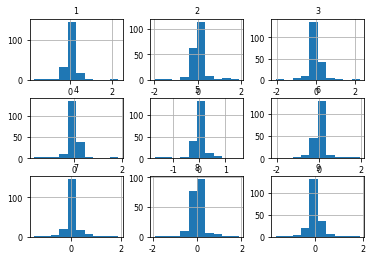

In [213]:
# histograms of the variables 
data_raw = pd.DataFrame(data) 
fig = data_raw.hist(xlabelsize=8, ylabelsize=8) 
[x.title.set_size(8) for x in fig.ravel()]
# show the plot 
plt.show()

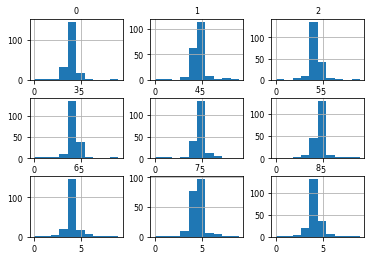

In [214]:
from sklearn.preprocessing import KBinsDiscretizer

# perform a uniform discretization transform of the dataset 
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform') 
data = discretizer.fit_transform(data)

# convert the array back to a dataframe 
data_uniform = pd.DataFrame(data) 
# histograms of the variables 
fig = data_uniform.hist(xlabelsize=8, ylabelsize=8) 
[x.title.set_size(8) for x in fig.ravel()] 
# show the plot 
plt.show()

#### Quantile Discretization

In [3]:
# read the data
data = pd.read_csv('data/train_complete.csv')
data.drop(columns=['id','label'], inplace=True)
data = data.loc[0:200]
data = data.iloc[:,0:9]

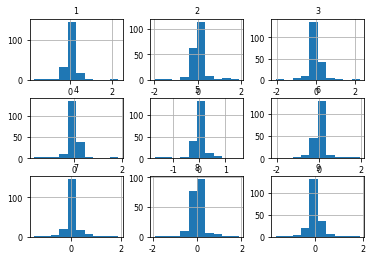

In [216]:
# histograms of the variables 
data_raw = pd.DataFrame(data) 
fig = data_raw.hist(xlabelsize=8, ylabelsize=8) 
[x.title.set_size(8) for x in fig.ravel()]
# show the plot 
plt.show()

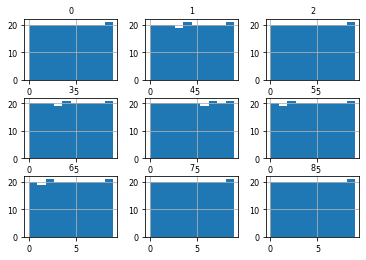

In [217]:
# perform a quantile discretization transform of the dataset 
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile') 
data = discretizer.fit_transform(data)

# convert the array back to a dataframe 
data_quantile = pd.DataFrame(data) 
# histograms of the variables 
fig = data_quantile.hist(xlabelsize=8, ylabelsize=8) 
[x.title.set_size(8) for x in fig.ravel()] 
# show the plot 
plt.show()

#### K-means Discretization

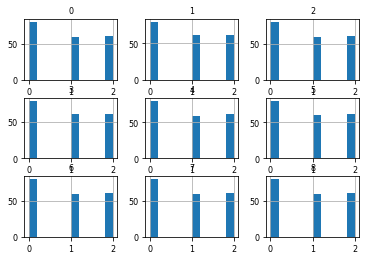

In [226]:
# perform a quantile discretization transform of the dataset 
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans') 
data = discretizer.fit_transform(data)

# convert the array back to a dataframe 
data_kmeans = pd.DataFrame(data) 
# histograms of the variables 
fig = data_kmeans.hist(xlabelsize=8, ylabelsize=8) 
[x.title.set_size(8) for x in fig.ravel()] 
# show the plot 
plt.show()

### Feature Selection

#### Filter Methods

##### • Pearson Correlation Coefficient

In [19]:
## read the data
train_data = pd.read_csv('data/train_complete.csv')
train_data.drop(train_data.columns[50:6000], axis=1, inplace=True)
y_train['label'] = train_data['label']
train_data.drop(columns=['label','id'], inplace=True)


In [20]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr

SelectKBest(lambda X, Y: np.array(map(lambda x:pearsonr(x, Y), X.T)).T, k=2).fit_transform(train_data, y_train)


TypeError: float() argument must be a string or a number, not 'map'

## Dimensionality Reduction

### PCA

In [2]:
# evaluate pca with logistic regression algorithm for classification 
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# define dataset 
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=30, n_informative=10, n_redundant=20, random_state=2)
    return X, y

# get a list of models to evaluate 
def get_models(): 
    models = dict() 
    for i in range(1,16): 
        steps = [('pca', PCA(n_components=i)), ('m', LogisticRegression())]
        models[str(i)] = Pipeline(steps=steps) 
    return models

# evaluate a given model using cross-validation 
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# define dataset 
X, y = get_dataset()
# get the models to evaluate 
models = get_models()
# evaluate the models and store results 
results, names = list(), list()
for name, model in models.items(): 
    scores = evaluate_model(model, X, y) 
    results.append(scores) 
    names.append(name) 
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>1 0.655 (0.050)
>2 0.657 (0.049)
>3 0.729 (0.039)
>4 0.728 (0.037)
>5 0.776 (0.034)
>6 0.780 (0.034)
>7 0.782 (0.033)
>8 0.821 (0.035)
>9 0.822 (0.032)
>10 0.829 (0.036)
>11 0.829 (0.036)
>12 0.829 (0.036)
>13 0.829 (0.036)
>14 0.829 (0.036)
>15 0.829 (0.036)


### LDA

In [1]:
# evaluate pca with logistic regression algorithm for classification 
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.pipeline import Pipeline 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

# define dataset 
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=30, n_informative=10, n_redundant=20, random_state=2, n_classes=10)
    return X, y

# get a list of models to evaluate 
def get_models(): 
    models = dict() 
    for i in range(1,10): 
        steps = [('lda', LinearDiscriminantAnalysis(n_components=i)), ('m', GaussianNB())] 
        models[str(i)] = Pipeline(steps=steps) 
    return models

# evaluate a given model using cross-validation 
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# define dataset 
X, y = get_dataset()
# get the models to evaluate 
models = get_models()
# evaluate the models and store results 
results, names = list(), list()
for name, model in models.items(): 
    scores = evaluate_model(model, X, y) 
    results.append(scores) 
    names.append(name) 
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>1 0.193 (0.031)
>2 0.285 (0.039)
>3 0.326 (0.040)
>4 0.370 (0.043)
>5 0.394 (0.052)
>6 0.412 (0.052)
>7 0.417 (0.047)
>8 0.424 (0.051)
>9 0.443 (0.043)
